# =========================
# TP2 — Pandas Baseline
# =========================

In [1]:
import pandas as pd
import numpy as np
import re
import psutil
import time
from codecarbon import EmissionsTracker
from collections import Counter


# ---------------------------------------------
# Helper function to measure each pipeline step
# ---------------------------------------------
def measure_step(step_name, framework, func, log):
    rows_analyzed = None
    result = None
    co2_kg = 0.0
    tracker = EmissionsTracker(measure_power_secs=1, save_to_file=False)
    start = time.time()
    try:
        tracker.start()
        start = time.time()
        result = func()
        co2_kg = tracker.stop()  # may be None or float
    except Exception as e:
        print(f"⚠️ CodeCarbon failed for {step_name}: {e}")
        try:
            maybe_co2 = tracker.stop()
            if maybe_co2:
                co2_kg = maybe_co2
        except Exception:
            pass
    finally:
        duration = time.time() - start
        memory_mb = psutil.virtual_memory().used / (1024 * 1024)

        # Handle None safely
        if co2_kg is None:
            co2_kg = 0.0

        if rows_analyzed is None:
            if isinstance(result, dict) and "rows_analyzed" in result:
                rows_analyzed = result["rows_analyzed"]
            elif isinstance(result, (int, float)) and not isinstance(result, bool):
                rows_analyzed = int(result)

        if rows_analyzed is None:
            rows_analyzed = 0

        # Estimate energy from CO₂ (1 kWh ≈ 0.233 kg CO₂) = 0.233 * 1000 = 233watt
        energy_kwh = (co2_kg / 0.233) * 1000 if co2_kg and co2_kg > 0 else 0.0
        efficiency_ratio = (rows_analyzed / co2_kg) if co2_kg and co2_kg > 0 else None

        log.append({
            "Step": step_name,
            "Framework": framework,
            "Duration (s)": round(duration, 3),
            "Energy (Wh)": round(energy_kwh, 6),
            "CO2 (kg)": round(co2_kg, 6),
            "Memory (MB)": round(memory_mb, 2),
            "Total rows analysed": int(rows_analyzed),
            "Efficiency ratio": round(efficiency_ratio, 6) if efficiency_ratio is not None else None
        })


# =========================================================
# ----------- TASK 1 : PANDAS PIPELINE ---------------------
# =========================================================

In [2]:

log_pandas = []

def pandas_pipeline():
    print("Running Pandas pipeline...")
    global books, reviews, merged, author_ratings, reviews_per_publisher, category_reviews, most_common_words

    # ---- Load ----
    def step_load_data():
        global books, reviews
        books = pd.read_csv("books_data.csv")
        reviews = pd.read_csv("Books_rating.csv")
    # measure_step("Load data", "Pandas", step_load_data, log_pandas)
    step_load_data()

    # ---- Clean ----
    def step_clean_data():
        books.fillna({"description": "", "publisher": "Unknown", "categories": "[]", "authors": "[]"}, inplace=True)
        reviews.fillna({"Price": 0, "review/text": "", "review/summary": ""}, inplace=True)

        def clean_list_column(x):
            if pd.isna(x): return []
            x = re.sub(r"[\[\]']", "", str(x))
            return [i.strip() for i in x.split(",") if i.strip()]

        books["authors"] = books["authors"].apply(clean_list_column)
        books["categories"] = books["categories"].apply(clean_list_column)
    # measure_step("Data cleaning", "Pandas", step_clean_data, log_pandas)
    step_clean_data()

    # ---- Join ----
    def step_join_data():
        global merged
        merged = pd.merge(reviews, books, on="Title", how="inner")
    # measure_step("Join datasets", "Pandas", step_join_data, log_pandas)
    step_join_data()
    # ---- Compute metrics ----
    def step_avg_rating_per_author():
        global author_ratings
        author_ratings = (
            merged.explode("authors")
            .groupby("authors")["review/score"]
            .mean()
            .reset_index()
            .rename(columns={"review/score": "avg_rating"})
        )
        return len(author_ratings)
    measure_step("Average rating per author", "Pandas", step_avg_rating_per_author, log_pandas)

    def step_reviews_per_publisher():
        global reviews_per_publisher
        reviews_per_publisher = (
            merged.groupby("publisher")["Id"]
            .count()
            .reset_index()
            .rename(columns={"Id": "num_reviews"})
        )
        return len(reviews_per_publisher)
    measure_step("Number of reviews per publisher", "Pandas", step_reviews_per_publisher, log_pandas)

    def step_top10_categories():
        global category_reviews
        category_reviews = (
            merged.explode("categories")
            .groupby("categories")["Id"]
            .count()
            .reset_index()
            .rename(columns={"Id": "num_reviews"})
            .sort_values(by="num_reviews", ascending=False)
            .head(10)
        )
        return len(category_reviews)
    measure_step("Top 10 most-reviewed categories", "Pandas", step_top10_categories, log_pandas)

    # ---- Text processing ----
    def step_avg_review_length():
        merged["review_length"] = merged["review/text"].apply(lambda x: len(str(x).split()))
        merged["review_length"].mean()
        return len(merged)
    measure_step("Average review length", "Pandas", step_avg_review_length, log_pandas)

    def step_most_common_words():
        global most_common_words
        all_words = " ".join(merged["review/text"]).lower().split()
        word_counts = Counter(all_words)
        most_common_words = pd.DataFrame(word_counts.most_common(10), columns=["word", "count"])
        return len(most_common_words)
    measure_step("Most frequent keywords", "Pandas", step_most_common_words, log_pandas)

    # ---- Save ----
    def step_save_results():
        author_ratings.to_csv("avg_rating_per_author.csv", index=False)
        reviews_per_publisher.to_csv("reviews_per_publisher.csv", index=False)
        category_reviews.to_csv("top10_categories.csv", index=False)
        most_common_words.to_csv("top10_keywords.csv", index=False)
    # measure_step("Save results", "Pandas", step_save_results, log_pandas)

    pd.DataFrame(log_pandas).to_csv("emissions_pandas.csv", index=False)
    print("✅ Pandas pipeline done → emissions_pandas.csv")

# Run Task 1
pandas_pipeline()


Running Pandas pipeline...


[codecarbon WARNING @ 11:06:14] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 11:06:14] [setup] RAM Tracking...
[codecarbon INFO @ 11:06:14] [setup] CPU Tracking...
[codecarbon WARNING @ 11:06:16] We saw that you have a Intel(R) Core(TM) Ultra 9 185H but we don't know it. Please contact us.
[codecarbon WARNING @ 11:06:16] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 11:06:16] CPU Model on constant consumption mode: Intel(R) Core(TM) Ultra 9 185H
[codecarbon WARNING @ 11:06:16] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:06:16] [setup] GPU Tracking...
[codecarbon INFO @ 11:06:16] No GPU found.
[codecarbon INFO @ 11:06:16] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
 

✅ Pandas pipeline done → emissions_pandas.csv


# =========================================================
# ----------- TASK 2 : PYSPARK PIPELINE --------------------
# =========================================================

In [3]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, split, size, lower, regexp_replace, avg, count
from pyspark.sql.types import StructType, StructField, StringType, LongType

log_spark = []

def spark_pipeline():
    print("\nRunning PySpark pipeline...")

    spark = SparkSession.builder \
        .appName("Books Reviews Spark CodeCarbon") \
        .master("local[*]") \
        .getOrCreate()

    # ---- Load ----
    def step_load_data():
        global books_df, reviews_df
        books_df = spark.read.option("header", True).csv("books_data.csv")
        reviews_df = spark.read.option("header", True).csv("Books_rating.csv")
    step_load_data()

    # ---- Clean ----
    def step_clean_data():
        global books_df_clean, reviews_df_clean
        books_df_clean = books_df.fillna({
            "description": "",
            "publisher": "Unknown",
            "categories": "[]",
            "authors": "[]"
        })
        reviews_df_clean = reviews_df.fillna({
            "Price": "0",
            "review/text": "",
            "review/summary": ""
        })
        books_df_clean = books_df_clean \
            .withColumn("authors", regexp_replace(col("authors"), r"[\[\]']", "")) \
            .withColumn("categories", regexp_replace(col("categories"), r"[\[\]']", "")) \
            .withColumn("authors", split(col("authors"), ",")) \
            .withColumn("categories", split(col("categories"), ","))
    step_clean_data()

    # ---- Join ----
    def step_join_data():
        global merged_df
        merged_df = reviews_df_clean.join(books_df_clean, on="Title", how="inner")
    step_join_data()

    # ---- Compute metrics ----
    def step_avg_rating_per_author():
        global author_ratings_df
        author_ratings_df = merged_df.withColumn("author", explode(col("authors"))) \
            .groupby("author").agg(avg(col("review/score").cast("float")).alias("avg_rating"))
        return author_ratings_df.count()
    measure_step("Average rating per author", "PySpark", step_avg_rating_per_author, log_spark)

    def step_reviews_per_publisher():
        global reviews_per_publisher_df
        reviews_per_publisher_df = merged_df.groupby("publisher").agg(count("Id").alias("num_reviews"))
        return reviews_per_publisher_df.count()
    measure_step("Number of reviews per publisher", "PySpark", step_reviews_per_publisher, log_spark)

    def step_top10_categories():
        global category_reviews_df
        category_reviews_df = merged_df.withColumn("category", explode(col("categories"))) \
            .groupby("category").agg(count("Id").alias("num_reviews")) \
            .orderBy(col("num_reviews").desc()).limit(10)
        return category_reviews_df.count()
    measure_step("Top 10 most-reviewed categories", "PySpark", step_top10_categories, log_spark)

    # ---- Text processing ----
    def step_avg_review_length():
        tmp = merged_df.withColumn("review_length", size(split(col("review/text"), " ")))
        tmp.selectExpr("avg(review_length)").collect()
        return tmp.count()
    measure_step("Average review length", "PySpark", step_avg_review_length, log_spark)

    
    def step_most_common_words():
        global top_words_df
    
        def _partition_top_words(rows):
            from collections import Counter
            import re
    
            counter = Counter()
            for row in rows:
                text = row[0]
                if text:
                    tokens = re.findall(r"[\w']+", text.lower())
                    counter.update(token for token in tokens if token)
    
            for word, count_value in counter.most_common(2000):
                yield word, count_value
    
        token_counts = (
            merged_df
            .select("review/text")
            .where(col("review/text").isNotNull())
            .rdd
            .mapPartitions(_partition_top_words)
            .reduceByKey(lambda a, b: a + b)
        )
    
        top_words = token_counts.takeOrdered(10, key=lambda kv: -kv[1])
        schema = StructType([
            StructField("word", StringType(), False),
            StructField("count", LongType(), False),
        ])
        if top_words:
            top_words_df = spark.createDataFrame(top_words, schema=schema)
        else:
            top_words_df = spark.createDataFrame([], schema=schema)
        return len(top_words)
    measure_step("Most frequent keywords", "PySpark", step_most_common_words, log_spark)

    # ---- Save ----
    def step_save_results():
        author_ratings_df.toPandas().to_csv("avg_rating_per_author_spark.csv", index=False)
        reviews_per_publisher_df.toPandas().to_csv("reviews_per_publisher_spark.csv", index=False)
        category_reviews_df.toPandas().to_csv("top10_categories_spark.csv", index=False)
        top_words_df.toPandas().to_csv("top10_keywords_spark.csv", index=False)

    spark.stop()

    pd.DataFrame(log_spark).to_csv("emissions_spark.csv", index=False)
    print("✅ PySpark pipeline done → emissions_spark.csv")

# Run Task 2
spark_pipeline()



Running PySpark pipeline...


[codecarbon WARNING @ 11:11:00] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 11:11:00] [setup] RAM Tracking...
[codecarbon INFO @ 11:11:00] [setup] CPU Tracking...
[codecarbon WARNING @ 11:11:01] We saw that you have a Intel(R) Core(TM) Ultra 9 185H but we don't know it. Please contact us.
[codecarbon WARNING @ 11:11:01] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 11:11:01] CPU Model on constant consumption mode: Intel(R) Core(TM) Ultra 9 185H
[codecarbon WARNING @ 11:11:01] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:11:01] [setup] GPU Tracking...
[codecarbon INFO @ 11:11:01] No GPU found.
[codecarbon INFO @ 11:11:01] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
 

⚠️ CodeCarbon failed for Most frequent keywords: An error occurred while calling o135.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 15 in stage 62.0 failed 1 times, most recent failure: Lost task 15.0 in stage 62.0 (TID 410) (10.94.57.60 executor driver): java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillReader.<init>(UnsafeSorterSpillReader.java:53)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillWriter.getReader(UnsafeSorterSpillWriter.java:159)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter$SpillableIterator.spill(UnsafeExternalSorter.java:628)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.spill(UnsafeExternalSorter.java:206)
	at org.apache.spark.memory.TaskMemoryManager.trySpillAndAcquire(TaskMemoryManager.java:228)
	at org.apache.spark.memory.TaskMemoryManager.acquireExecutionMemory(TaskMemoryManager.java:191)
	at org.apach

C:\Users\Gaurav Chugh\AppData\Local\Temp\ipykernel_31068\2873092671.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg, x="Framework", y="CO2 (kg)", ax=axes[0], palette="muted")
C:\Users\Gaurav Chugh\AppData\Local\Temp\ipykernel_31068\2873092671.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg, x="Framework", y="Duration (s)", ax=axes[1], palette="muted")


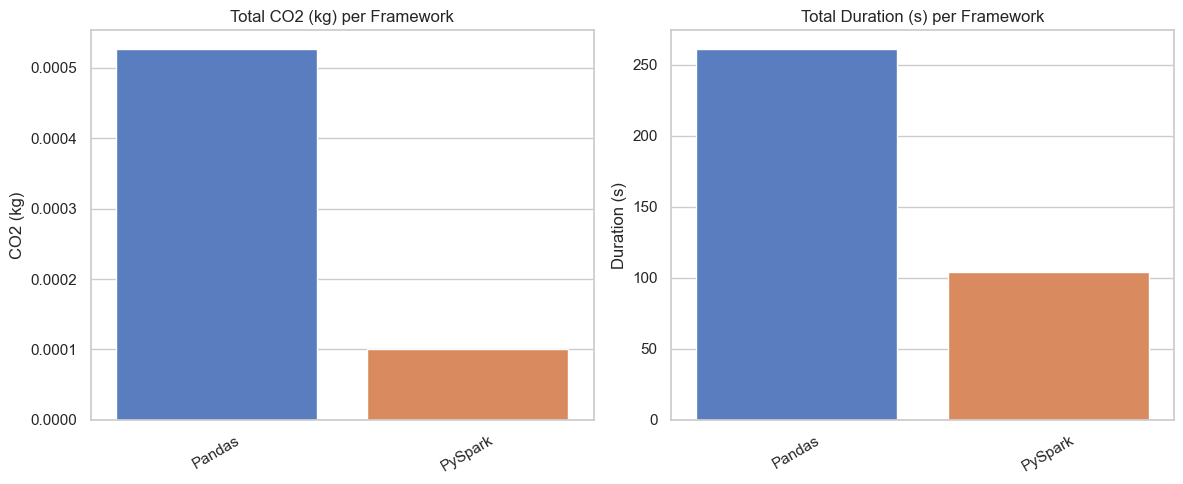

In [1]:
# Install seaborn if missing: uncomment next line
# !pip install seaborn

import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

files = glob.glob("emissions_*.csv")
if not files:
    raise FileNotFoundError("No emissions_*.csv files found in the working directory.")

dfs = [pd.read_csv(f) for f in files]
df = pd.concat(dfs, ignore_index=True)

# Ensure numeric columns
df["CO2 (kg)"] = pd.to_numeric(df.get("CO2 (kg)", 0), errors="coerce").fillna(0)
df["Duration (s)"] = pd.to_numeric(df.get("Duration (s)", 0), errors="coerce").fillna(0)

agg = df.groupby("Framework", as_index=False).agg({"CO2 (kg)": "sum", "Duration (s)": "sum"})

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(data=agg, x="Framework", y="CO2 (kg)", ax=axes[0], palette="muted")
axes[0].set_title("Total CO2 (kg) per Framework")
axes[0].set_xlabel("")
axes[0].tick_params(axis='x', rotation=30)

sns.barplot(data=agg, x="Framework", y="Duration (s)", ax=axes[1], palette="muted")
axes[1].set_title("Total Duration (s) per Framework")
axes[1].set_xlabel("")
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.savefig("emissions_by_framework.png", dpi=150)
plt.show()